## $$\textbf{Data challenge on DNA Sequence}$$

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data Preprocessing

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization


# Load data
Xtr = pd.read_csv('/content/drive/MyDrive/INN/Data/Xtr.csv', header = 0)
Ytr = pd.read_csv('/content/drive/MyDrive/INN/Data/Ytr.csv', header = 0)
Xte = pd.read_csv('/content/drive/MyDrive/INN/Data/Xte.csv', header = 0)

# One-hot encoding function
def one_hot_encode(sequence):
    encoding_dict = {'A': [1,0,0,0], 'T': [0,1,0,0],
                    'C': [0,0,1,0], 'G': [0,0,0,1]}
    return [encoding_dict.get(nuc, [0,0,0,0]) for nuc in sequence]

# Process sequences
Xtr_encoded = np.array([one_hot_encode(seq) for seq in Xtr['seq']])
Xte_encoded = np.array([one_hot_encode(seq) for seq in Xte['seq']])

max_length_xtr = max(len(seq) for seq in Xtr_encoded)
max_length_xte = max(len(seq) for seq in Xte_encoded)

max_length = max(max_length_xtr, max_length_xte)

Xtr_padded = pad_sequences(Xtr_encoded, maxlen=max_length, padding='post', dtype='float32')
Xte_padded = pad_sequences(Xte_encoded, maxlen=max_length, padding='post', dtype='float32')

# Prepare labels
y = Ytr['Bound'].values.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(Xtr_padded, y, test_size=0.2, random_state=42)

First, we implement a simple $1D$ CNN with an $L2$ regularizer to avoid Overfitting

In [3]:
# Model Implementation

# Build 1D CNN model
def build_cnn_model():
    model = Sequential([
        Conv1D(64, kernel_size=10, activation='relu', kernel_regularizer=l2(0.001), input_shape=(max_length, 4)),

        Dropout(0.4),
        MaxPooling1D(3),
        Conv1D(32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.1)),

        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')])


    model.compile(optimizer=Adam(learning_rate=0.001235),
             loss='binary_crossentropy',
             metrics=['accuracy'])
    return model


# Training
cnn_model = build_cnn_model()
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=128,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5) ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5154 - loss: 4.5620 - val_accuracy: 0.5225 - val_loss: 3.4191 - learning_rate: 0.0012
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5130 - loss: 3.1292 - val_accuracy: 0.5050 - val_loss: 2.3454 - learning_rate: 0.0012
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5194 - loss: 2.1537 - val_accuracy: 0.5425 - val_loss: 1.6509 - learning_rate: 0.0012
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4997 - loss: 1.5348 - val_accuracy: 0.4900 - val_loss: 1.2290 - learning_rate: 0.0012
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5168 - loss: 1.1593 - val_accuracy: 0.4850 - val_loss: 0.9832 - learning_rate: 0.0012
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5324 - loss: 0.9431 - val_accuracy: 0.5275 - val_loss: 0.8445 - learning_rate: 0.0012
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5222 - loss: 0.8247 - val

Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 Accuracy: 0.5125, Loss: 0.6950
Fold 2/5
Fold 2 Accuracy: 0.7050, Loss: 0.6079
Fold 3/5
Fold 3 Accuracy: 0.6825, Loss: 0.6137
Fold 4/5
Fold 4 Accuracy: 0.7100, Loss: 0.6149
Fold 5/5
Fold 5 Accuracy: 0.5025, Loss: 0.6936

Average Accuracy: 0.6225 +/- 0.0944
Best Accuracy: 0.7100


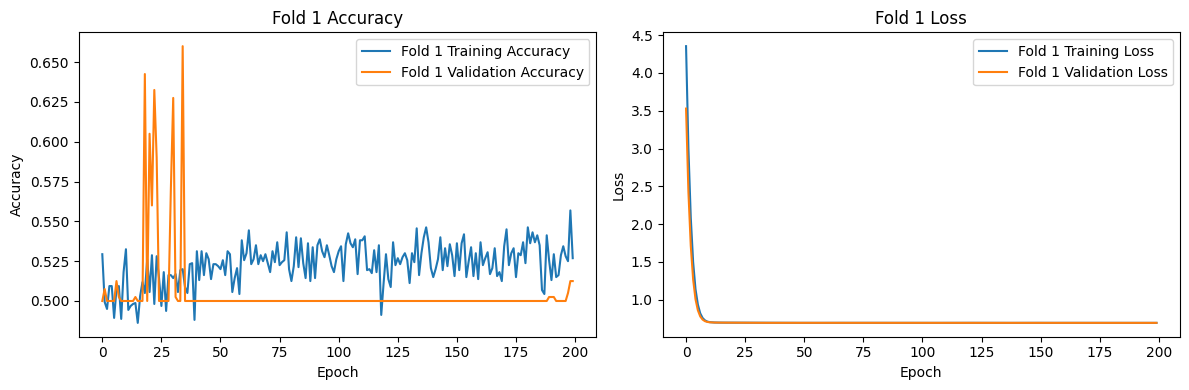

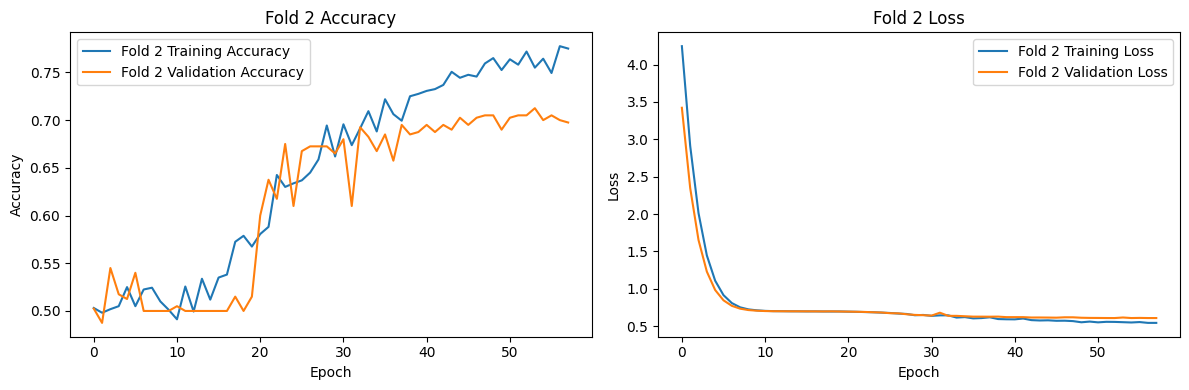

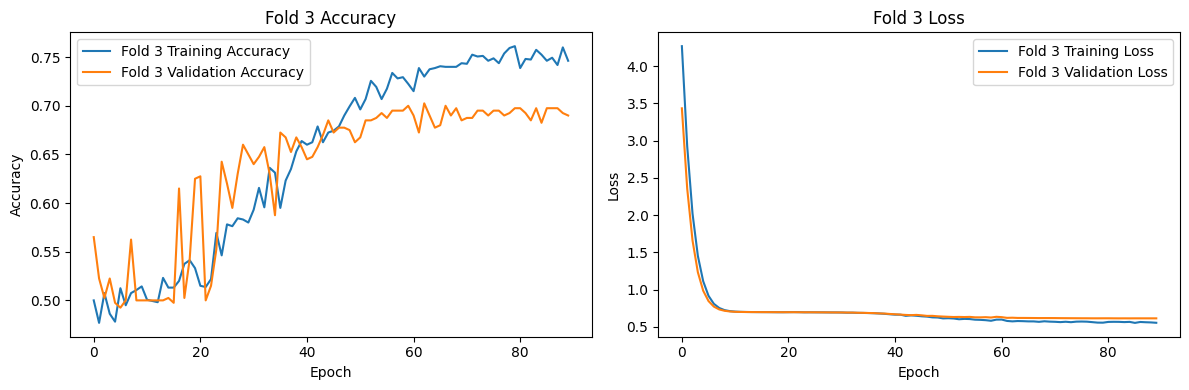

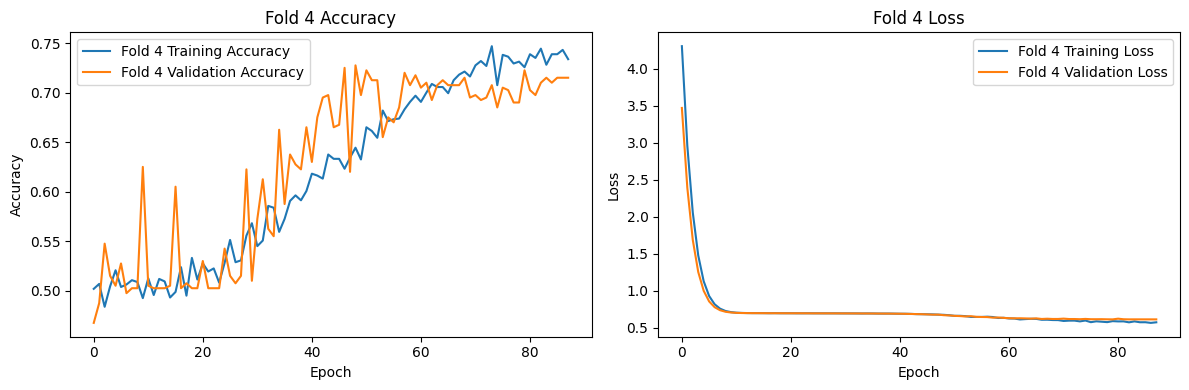

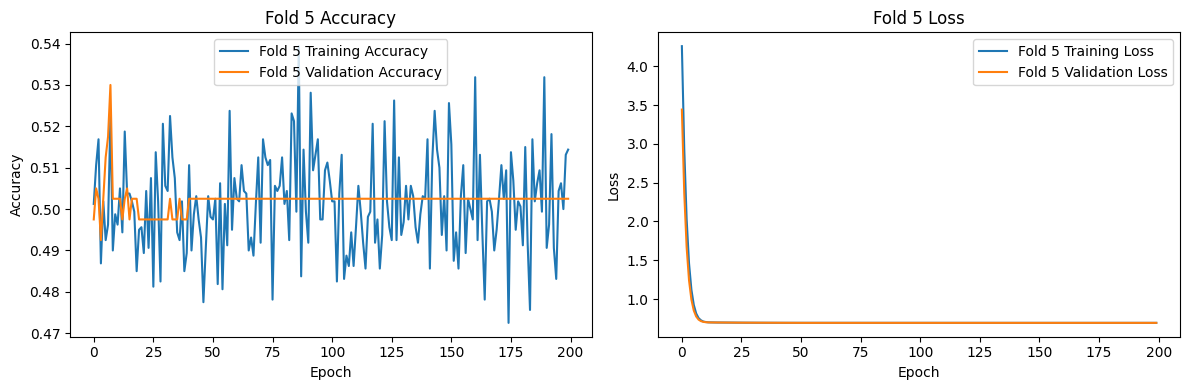

In [4]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

def train_and_evaluate(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=128):
    """Trains and evaluates the model, returning the training history."""
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5)
        ],verbose=0)
    return history


# Stratified K-Fold Cross Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []
histories = []
best_accuracy = 0.0
best_model = None

for fold, (train_index, val_index) in enumerate(skf.split(Xtr_padded, y)):
    print(f"Fold {fold + 1}/{n_splits}")

    # Split data into train and validation sets for this fold
    X_train, X_val = Xtr_padded[train_index], Xtr_padded[val_index] # split Xtr_padded
    y_train, y_val = y[train_index], y[val_index]

    # Build a new model for each fold
    cnn_model = build_cnn_model()

    # Train and evaluate the model
    history = train_and_evaluate(cnn_model, X_train, y_train, X_val, y_val)
    histories.append(history)

    # Evaluate the model on the validation set
    loss, accuracy = cnn_model.evaluate(X_val, y_val, verbose=0)
    fold_accuracies.append(accuracy)
    fold_losses.append(loss)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

    # Save the model if it's the best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = cnn_model

print(f"\nAverage Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Plot the training history for each fold
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'Fold {i+1} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
    plt.title(f'Fold {i+1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Fold {i+1} Training Loss')
    plt.plot(history.history['val_loss'], label=f'Fold {i+1} Validation Loss')
    plt.title(f'Fold {i+1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
y_pred = cnn_model.predict(Xte_padded).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)

# Create submission file
submission_cnn = pd.DataFrame({
    'Id': Xte.index,
    'Bound': y_pred_binary
}).sort_values('Id')

submission_cnn.to_csv('Final_Submission.csv', index=False)

print("CNN submission file created: Final_Submission.csv")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
CNN submission file created: Final_Submission.csv
